In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe' 

plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv("Amazon_Reviews.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
dfg = df.groupby('Score').count().reset_index()

In [5]:
px.bar(dfg,
         x='Score',
         y='Id',
         #color='Items',
         barmode='stack')

In [6]:
example = df['Text'][50]

In [7]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

### NLTK's VADER Model

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
#     print(row)
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
dfg.head(5)

,Score,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text
0,1,98,98,98,98,98,98,98,98,98
1,2,47,47,47,47,47,47,47,47,47
2,3,75,75,75,75,75,75,75,75,75
3,4,138,138,138,138,138,138,138,138,138
4,5,642,642,642,642,642,642,642,642,642


In [11]:
sentiment_table = pd.DataFrame(res).T
sentiment_table = sentiment_table.reset_index().rename(columns={'index':'Id'})
sentiment_table = sentiment_table.merge(df, how="left")
sentiment_table.head(1)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.0,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


<AxesSubplot:xlabel='Score', ylabel='neg'>

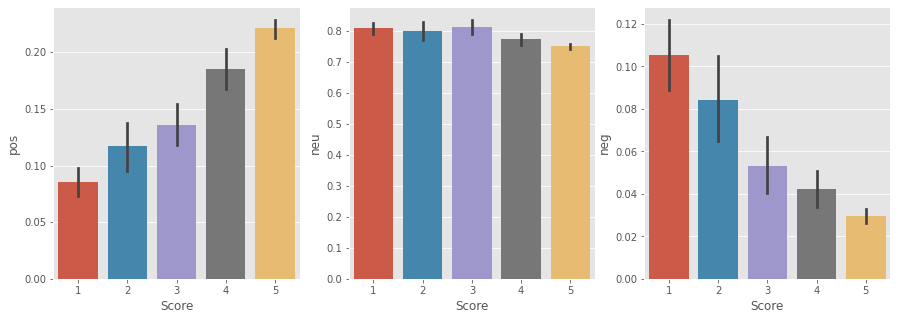

In [12]:
fig, axs = plt.subplots(1,3 , figsize = (15,5))
sns.barplot(data= sentiment_table, x='Score', y='pos', ax = axs[0])
sns.barplot(data= sentiment_table, x='Score', y='neu', ax = axs[1])
sns.barplot(data= sentiment_table, x='Score', y='neg', ax = axs[2])

### Huggingface RoBERTa Model

In [13]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
#roberta model

def roberta_polarity(example):
    encoded_text = tokenizer(example, return_tensors='pt',padding=True, truncation=True,max_length=50, add_special_tokens = True)
#     encoded_text = tokenizer.encode(example, padding=True, truncation=True,max_length=50, add_special_tokens = True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    score_dict = {
        'roberta_neg': scores[0],
        'reberta_neu': scores[1],
        'reberta_pos': scores[2]
    }

    return (score_dict)

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [17]:
res = {}
rob_res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
#     res[myid] = sia.polarity_scores(text)
    rob_res[myid] = roberta_polarity(text)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
RobSentiment_table = pd.DataFrame(rob_res).T
RobSentiment_table = RobSentiment_table.reset_index().rename(columns={'index':'Id'})
RobSentiment_table = RobSentiment_table.merge(df, how="left")
RobSentiment_table.head(1)

,Id,roberta_neg,reberta_neu,reberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.006828,0.048168,0.945004,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [19]:
final = RobSentiment_table.merge(sentiment_table, how="inner")
final.columns

Index(['Id', 'roberta_neg', 'reberta_neu', 'reberta_pos', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'neg',
       'neu', 'pos', 'compound'],
      dtype='object')

In [20]:
final = final[['Id', 'roberta_neg', 'reberta_neu', 'reberta_pos', 'neg',
       'neu', 'pos', 'compound', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']]
final.head(3)

,Id,roberta_neg,reberta_neu,reberta_pos,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.006828,0.048168,0.945004,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.034559,0.786570,0.178871,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


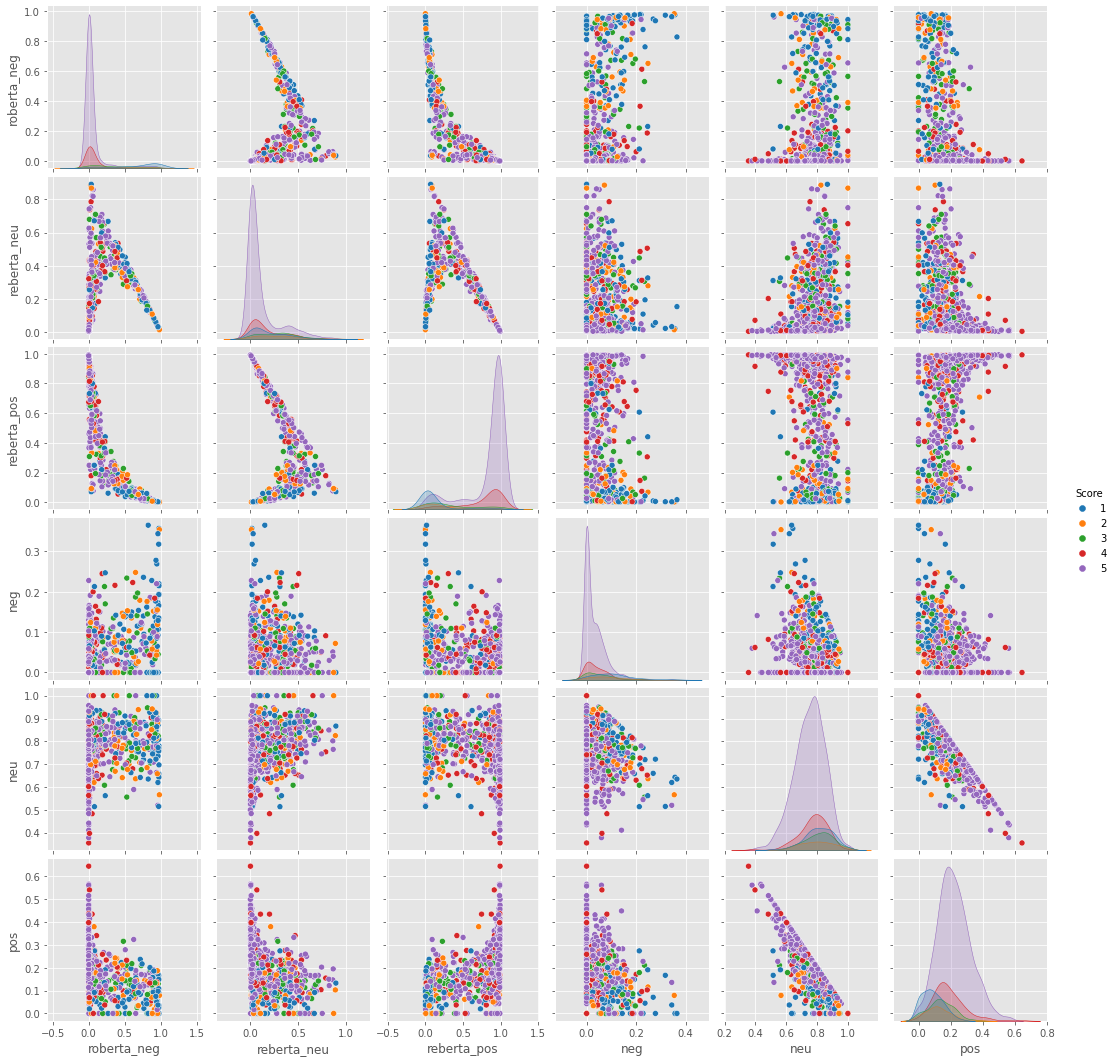

In [21]:
sns.pairplot(data = final, vars =['roberta_neg', 'reberta_neu', 'reberta_pos', 'neg',
       'neu', 'pos'],
            hue="Score",
            palette="tab10")


### Using Transformers pipeline Function

In [22]:
from transformers import pipeline

In [23]:
Sent_pipeline = pipeline("sentiment-analysis",truncation=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [24]:
Sent_pipeline("Bruh")

[{'label': 'POSITIVE', 'score': 0.542670488357544}]

In [25]:
trans_res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        trans_res[myid] = Sent_pipeline(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
dic = {}
for i in trans_res:
    for j in trans_res[i]:
        lis = list(j.values())
        dic[i] = lis[0],lis[1]

In [27]:
Transformer_table = pd.DataFrame(dic).T
Transformer_table= Transformer_table.reset_index().rename(columns={'index':'Id',0:'Prediction',1:'Pred_rating'})
Transformer_table = Transformer_table.merge(df, how="left")
Transformer_table.head(3)

,Id,Prediction,Pred_rating,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,POSITIVE,0.998385,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,NEGATIVE,0.999525,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,POSITIVE,0.999765,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [28]:
Transformer_table['Pred_rating'] = np.where(Transformer_table['Prediction'] == 'NEGATIVE',(Transformer_table['Pred_rating']*-1) , Transformer_table['Pred_rating'])
Transformer_table.head(3)


,Id,Prediction,Pred_rating,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,POSITIVE,0.998385,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,NEGATIVE,-0.999525,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,POSITIVE,0.999765,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [29]:
px.histogram(Transformer_table, x="Prediction",y="Score", color="Score", histfunc="count" )

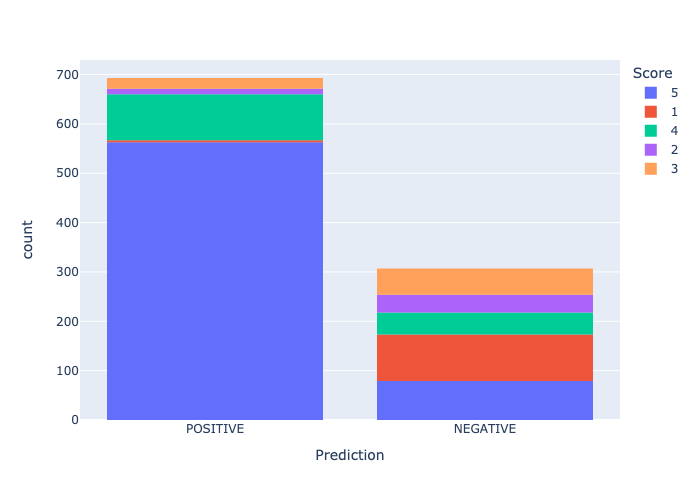

In [33]:
import plotly.io as pio
fig1 = px.histogram(Transformer_table, x="Prediction",y="Score", color="Score", histfunc="count" )
fig1.show(renderer="png")